In [709]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt

from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.stats.diagnostic import acorr_ljungbox



In [710]:
#Base de dados dos ultimos 10 anos
TabIbov = "https://raw.githubusercontent.com/Naiderossi/TechChallengeF2/main/Ibovespa3.csv"
#TabIbov = "/content/ibovespa3.csv"
df= pd.read_csv(TabIbov, sep=',' )
df.head()
df.shape

(2480, 7)

In [711]:
#Transformando a coluna Data em datetime
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)

In [712]:
#Realizando a ordenação do df
df.sort_values(by='Data', inplace=True, ascending=True)

In [713]:
#Colocando a a coluna Data como índice
df.set_index('Data', inplace=True)

In [714]:
df.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2015-02-02,47.651,46.933,47.684,46.760,"3,25M","1,58%"
2015-02-03,48.964,47.664,48.993,47.664,"4,82M","2,76%"
2015-02-04,49.301,48.965,49.718,48.214,"4,81M","0,69%"
2015-02-05,49.234,49.299,49.816,49.020,"4,00M","-0,14%"
2015-02-06,48.792,49.231,49.231,48.209,"4,59M","-0,90%"


In [715]:
#Removendo simbolo percentual e transformando para decimal a coluna Var%
df['Var%'] = df['Var%'].str.replace(',', '.').str.replace('%', '')
df['Var%'] = pd.to_numeric(df['Var%'], errors='coerce') / 100

In [716]:
# Ajustar bilhões e milhões corretamente
df.replace({',': '.', 'K': 'e3','B': 'e9', 'M': 'e6'}, regex=True, inplace=True)  # Substituir símbolos

# Converter colunas numéricas para float (caso tenham sido transformadas em string)
df = df.apply(pd.to_numeric, errors='coerce')

df.head()


,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2015-02-02,47.651,46.933,47.684,46.760,3250000.0,0.0158
2015-02-03,48.964,47.664,48.993,47.664,4820000.0,0.0276
2015-02-04,49.301,48.965,49.718,48.214,4810000.0,0.0069
2015-02-05,49.234,49.299,49.816,49.020,4000000.0,-0.0014
2015-02-06,48.792,49.231,49.231,48.209,4590000.0,-0.0090


In [717]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2480 entries, 2015-02-02 to 2025-01-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    2480 non-null   float64
 1   Abertura  2480 non-null   float64
 2   Máxima    2480 non-null   float64
 3   Mínima    2480 non-null   float64
 4   Vol.      2479 non-null   float64
 5   Var%      2480 non-null   float64
dtypes: float64(6)
memory usage: 135.6 KB


In [718]:
#Verificando se existem nulos
linhas_nulas = df[df.isnull().any(axis=1)]
linhas_nulas

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2016-02-10,40.377,40.592,40.592,39.96,NaN,-0.0053


In [719]:
#Calcular a média do volume (ignorando valores nulos)
media_vol = df["Vol."].mean()

# Preencher os valores nulos com a mediana
df["Vol."]= df['Vol.'].fillna(media_vol)

In [720]:
df.isnull().sum()

,0
Último,0
Abertura,0
Máxima,0
Mínima,0
Vol.,0
Var%,0


In [721]:
df.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2015-02-02,47.651,46.933,47.684,46.760,3250000.0,0.0158
2015-02-03,48.964,47.664,48.993,47.664,4820000.0,0.0276
2015-02-04,49.301,48.965,49.718,48.214,4810000.0,0.0069
2015-02-05,49.234,49.299,49.816,49.020,4000000.0,-0.0014
2015-02-06,48.792,49.231,49.231,48.209,4590000.0,-0.0090


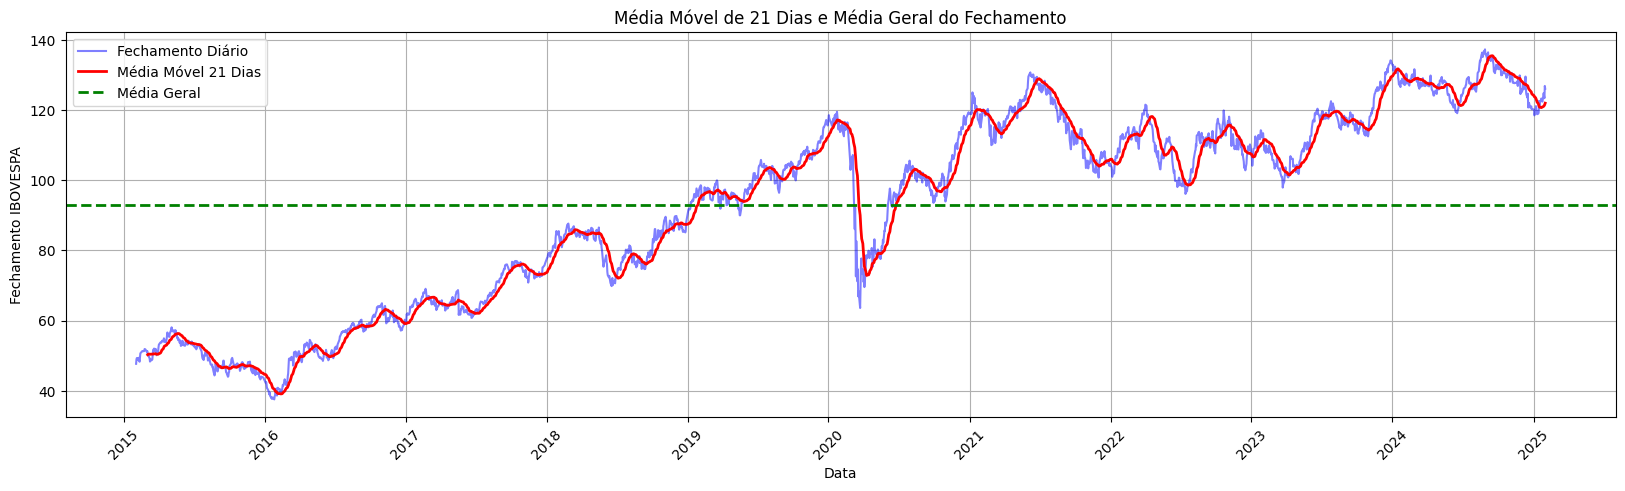

In [722]:
#Média móvel dos ultimos 21 dias (pregão)

df["Media_Movel_21d"] = df["Último"].rolling(window=21).mean()

#média geral do fechamento
media_geral = df["Último"].mean()

plt.figure(figsize=(20, 5))
plt.plot(df.index, df["Último"], label="Fechamento Diário", color="blue", alpha=0.5)
plt.plot(df.index, df["Media_Movel_21d"], label="Média Móvel 21 Dias", color="red", linewidth=2)
plt.axhline(y=media_geral, color="green", linestyle="dashed", linewidth=2, label="Média Geral")


plt.title("Média Móvel de 21 Dias e Média Geral do Fechamento")
plt.xlabel("Data")
plt.ylabel("Fechamento IBOVESPA")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Analisando variações por dia do mês e mês no ano

In [723]:
df['Dia'] = df.index.day
df['Semana'] = [dt.weekofyear for dt in df.index]
df['mes'] = df.index.month
df['ano'] = df.index.year

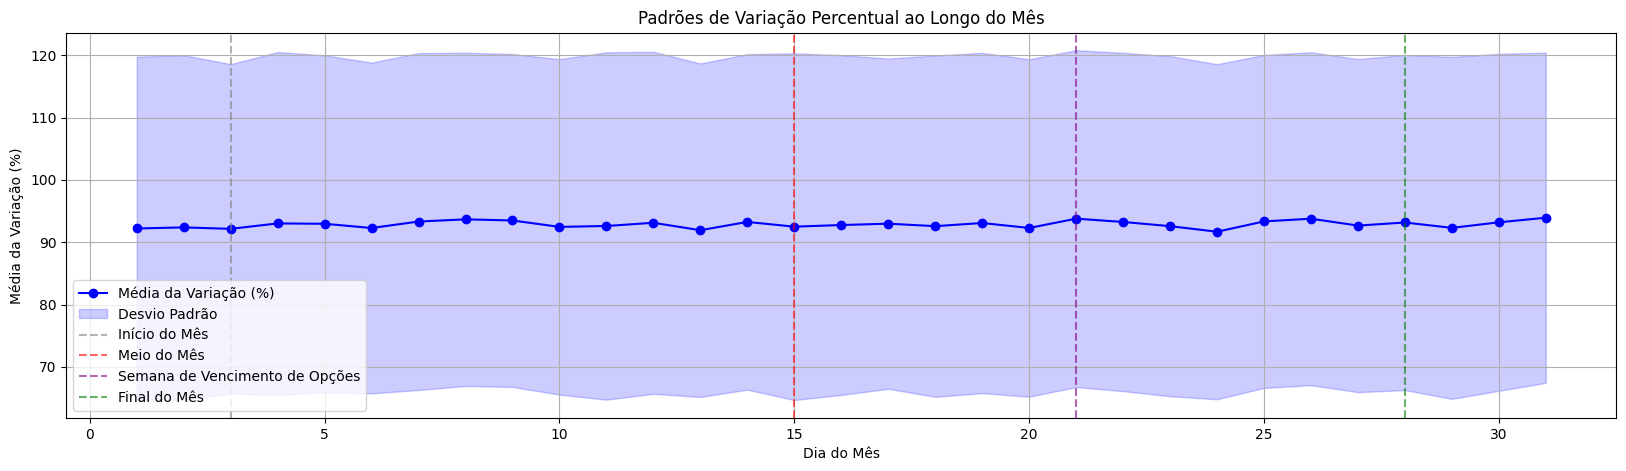

(          mean        std
 Dia                      
 1    92.201167  27.548989
 2    92.373753  27.629307
 3    92.140494  26.423955
 4    93.010892  27.495103
 5    92.952821  27.028547
 6    92.277736  26.529823
 7    93.312395  27.024300
 8    93.666365  26.727202
 9    93.484321  26.702582
 10   92.455536  26.909464
 11   92.601488  27.855118
 12   93.112293  27.437268
 13   91.923271  26.749680
 14   93.251060  26.907321
 15   92.489921  27.809095
 16   92.754277  27.254715
 17   92.971155  26.487990
 18   92.572459  27.377548
 19   93.079893  27.296291
 20   92.280700  27.066706
 21   93.775545  27.017672
 22   93.246425  27.136164
 23   92.572302  27.275913
 24   91.679603  26.876787
 25   93.333972  26.706668
 26   93.769250  26.702023
 27   92.663105  26.718085
 28   93.160867  26.886092
 29   92.295833  27.428875
 30   93.188757  27.031208
 31   93.924727  26.483198,
 None)

In [724]:


# Calcular a média e volatilidade da variação percentual por dia do mês
padroes_mes = df.groupby("Dia")["Último"].agg(["mean", "std"])

# Plotar os padrões mensais
plt.figure(figsize=(20, 5))
plt.plot(padroes_mes.index, padroes_mes["mean"], marker="o", linestyle="-", label="Média da Variação (%)", color="b")
plt.fill_between(padroes_mes.index,
                 padroes_mes["mean"] - padroes_mes["std"],
                 padroes_mes["mean"] + padroes_mes["std"],
                 color="b", alpha=0.2, label="Desvio Padrão")
plt.axvline(3, color="gray", linestyle="--", alpha=0.6, label="Início do Mês")
plt.axvline(15, color="red", linestyle="--", alpha=0.6, label="Meio do Mês")
plt.axvline(21, color="purple", linestyle="--", alpha=0.6, label="Semana de Vencimento de Opções")
plt.axvline(28, color="green", linestyle="--", alpha=0.6, label="Final do Mês")

plt.xlabel("Dia do Mês")
plt.ylabel("Média da Variação (%)")
plt.title("Padrões de Variação Percentual ao Longo do Mês")
plt.legend()
plt.grid()

# Exibir os dados estatísticos e gráfico
padroes_mes, plt.show()


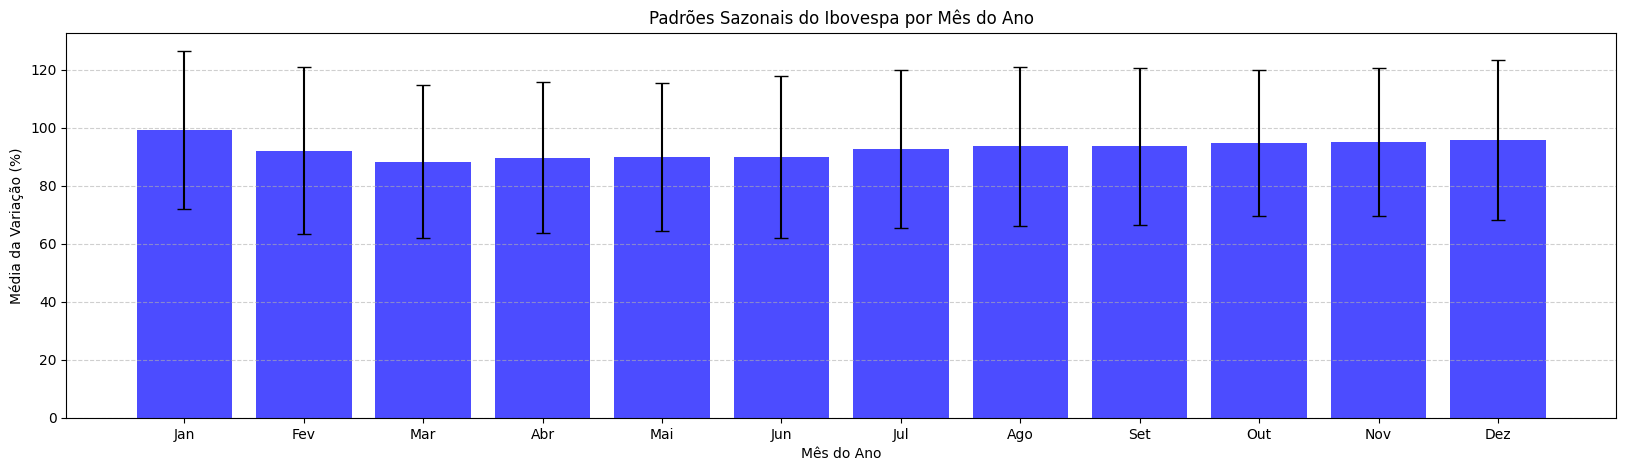

In [725]:
# Calcular a média e volatilidade da variação percentual por dia do mês
year_patterns = df.groupby("mes")["Último"].agg(["mean", "std"])

plt.figure(figsize=(20, 5))
plt.bar(year_patterns.index, year_patterns["mean"], yerr=year_patterns["std"], capsize=5, color="blue", alpha=0.7)
plt.xlabel("Mês do Ano")
plt.ylabel("Média da Variação (%)")
plt.title("Padrões Sazonais do Ibovespa por Mês do Ano")
plt.xticks(range(1, 13), ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez"])
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


*  Padrão Mensal: A IBOVESPA tende a ser ligeiramente mais alta no final do mês e mais baixa no meio do mês.
*  Volatilidade: Alguns dias apresentam desvios padrão maiores, sugerindo que nesses períodos há mais incerteza no mercado.

# Analisando estacionariedade da variável target

In [726]:

# Teste ADF
resultado_adf = adfuller(df["Último"].dropna())
print(f"Estatística ADF: {resultado_adf[0]}")
print(f"Valor-p: {100*resultado_adf[1]:.2f}%")


# Interpretação
if resultado_adf[1] < 0.05:
    print("A série é estacionária.")
else:
    print("A série não é estacionária.")

Estatística ADF: -1.4980466481891914
Valor-p: 53.45%
A série não é estacionária.


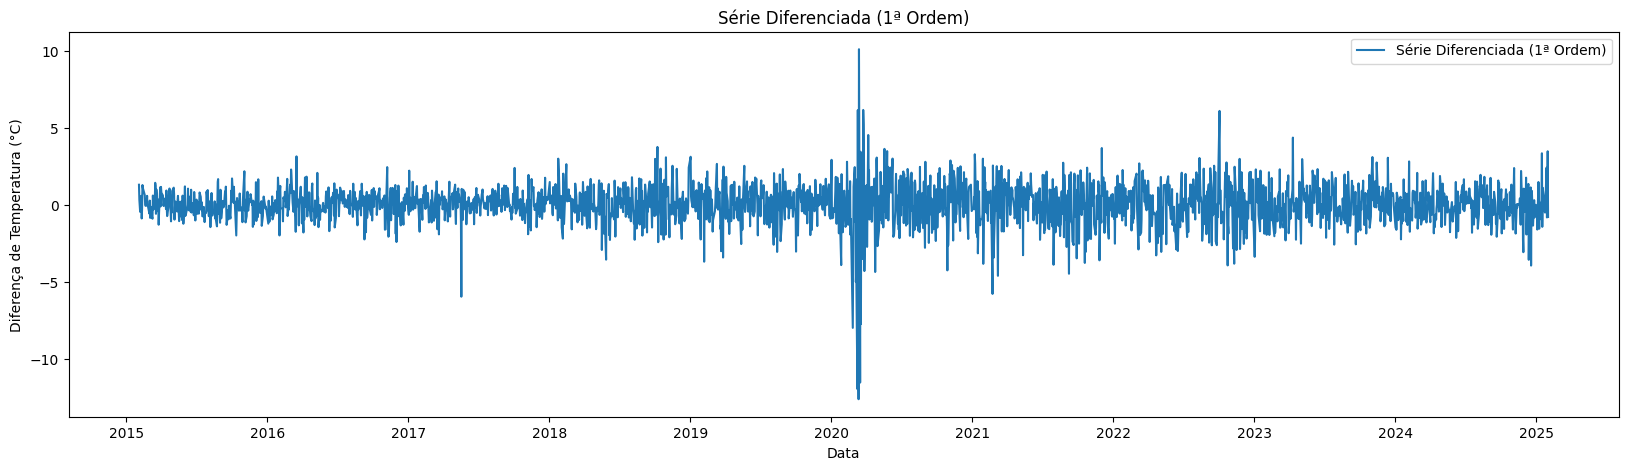

In [727]:
# Diferenciação de primeira ordem
df["Último_diff"] = df["Último"].diff().dropna()

# Plot da série diferenciada
plt.figure(figsize=(20, 5))
plt.plot(df.index, df["Último_diff"], label="Série Diferenciada (1ª Ordem)")
plt.title("Série Diferenciada (1ª Ordem)")
plt.xlabel("Data")
plt.ylabel("Diferença de Temperatura (°C)")
plt.legend()
plt.show()

In [728]:
resultado_adf_diff = adfuller(df["Último_diff"].dropna())
print(f"Estatística ADF: {resultado_adf_diff[0]}")
print(f"Valor-p: {100*resultado_adf_diff[1]:.4}%")

# Interpretação
if resultado_adf_diff[1] < 0.05:
    print("A série diferenciada é estacionária.")
else:
    print("A série diferenciada não é estacionária.")

Estatística ADF: -15.870907997177056
Valor-p: 8.984e-27%
A série diferenciada é estacionária.


Text(0.5, 1.0, 'Função de Autocorrelação (ACF)')

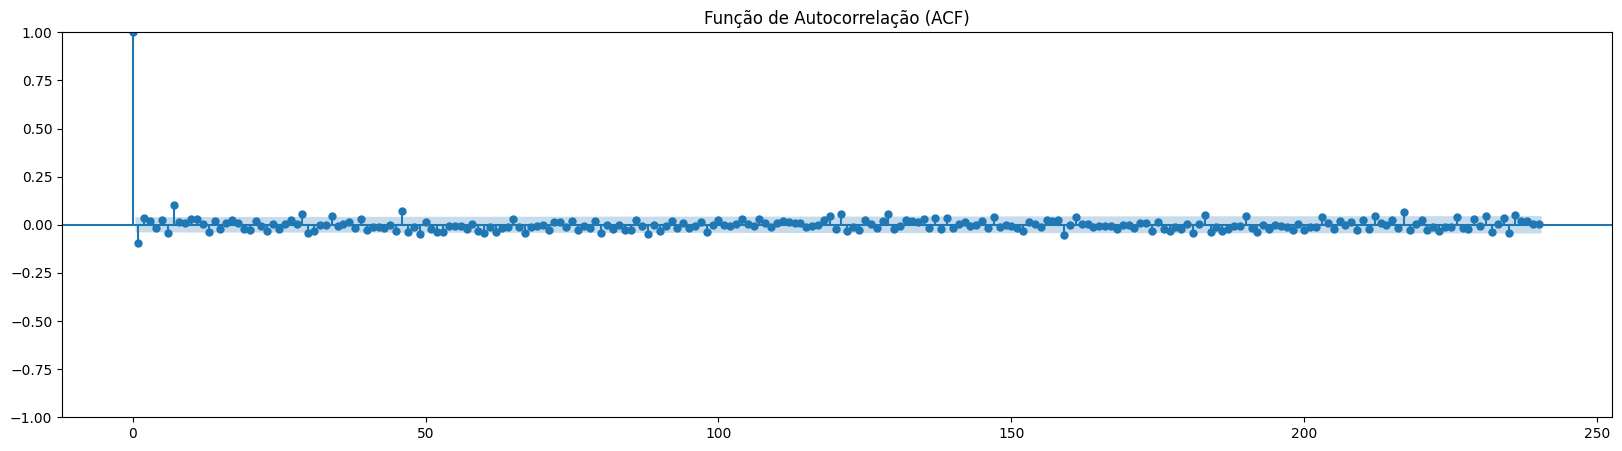

In [729]:
# Plot da ACF e PACF da série diferenciada de 1 ordem
plt.figure(figsize=(20, 5))
plot_acf(df["Último_diff"].dropna(), ax=plt.gca(), lags=240)
plt.title("Função de Autocorrelação (ACF)")

Text(0.5, 1.0, 'Função de Autocorrelação (PACF)')

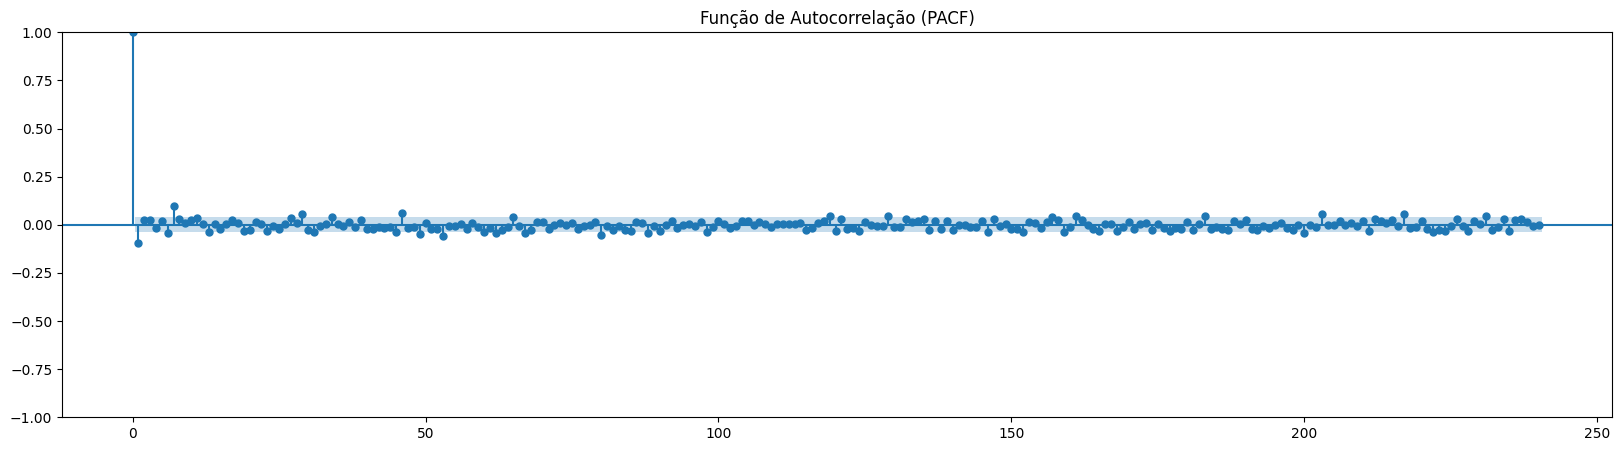

In [730]:
plt.figure(figsize=(20, 5))
plot_pacf(df["Último_diff"].dropna(), ax=plt.gca(), lags=240)
plt.title("Função de Autocorrelação (PACF)")



---


Os picos de autocorrelação no ACF e PACF parecem ocorrer em intervalos regulares, o que  pode ser um indicativo de sazonalidade. Nesse caso será necessário aplicar diferenciação sazonal, optando por um shift de 240 dias, pois é a média de dias úteis em um ano.


---



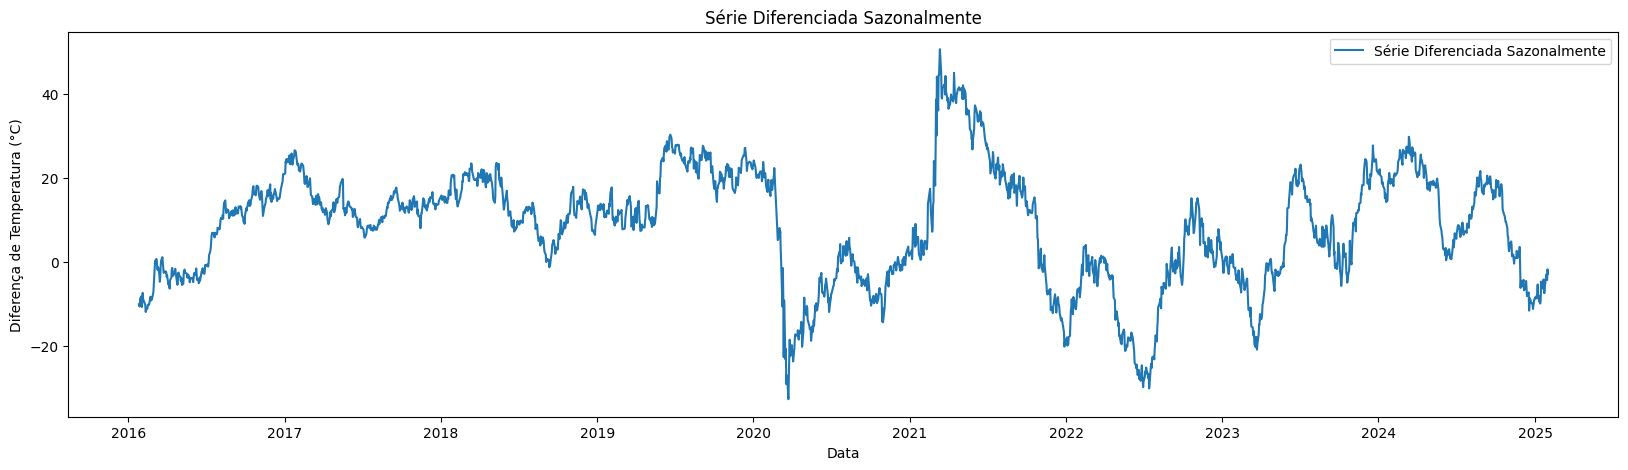

In [731]:
# Diferenciação sazonal (período de 240 dias úteis)
df["Ultimo_seasonal_diff"] = df["Último"] - df["Último"].shift(240)
df["Ultimo_seasonal_diff"] = df["Ultimo_seasonal_diff"].dropna()

# Plot da série sazonalmente diferenciada
plt.figure(figsize=(20, 5))
plt.plot(
    df.index, df["Ultimo_seasonal_diff"], label="Série Diferenciada Sazonalmente"
)
plt.title("Série Diferenciada Sazonalmente")
plt.xlabel("Data")
plt.ylabel("Diferença de Temperatura (°C)")
plt.legend()

In [732]:
resultado_adf_seasonaldiff = adfuller(df["Ultimo_seasonal_diff"].dropna())
print(f"Estatística ADF: {resultado_adf_diff[0]}")
print(f"Valor-p: {100*resultado_adf_diff[1]:.4}%")

# Interpretação
if resultado_adf_diff[1] < 0.05:
    print("A série diferenciada é estacionária.")
else:
    print("A série diferenciada não é estacionária.")

Estatística ADF: -15.870907997177056
Valor-p: 8.984e-27%
A série diferenciada é estacionária.


Text(0.5, 1.0, 'Função de Autocorrelação (ACF)')

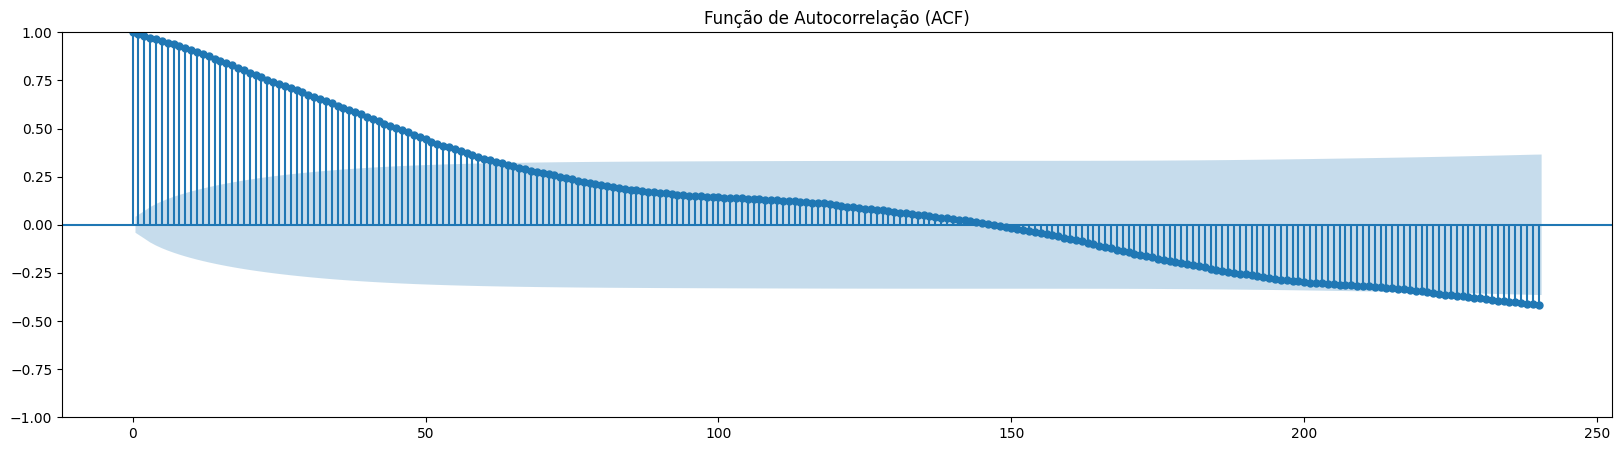

In [733]:
# Plot da ACF e PACF da série diferenciada sazonalmente
plt.figure(figsize=(20, 5))
plot_acf(df["Ultimo_seasonal_diff"].dropna(), ax=plt.gca(), lags =240)
plt.title("Função de Autocorrelação (ACF)")

Text(0.5, 1.0, 'Função de Autocorrelação (PACF)')

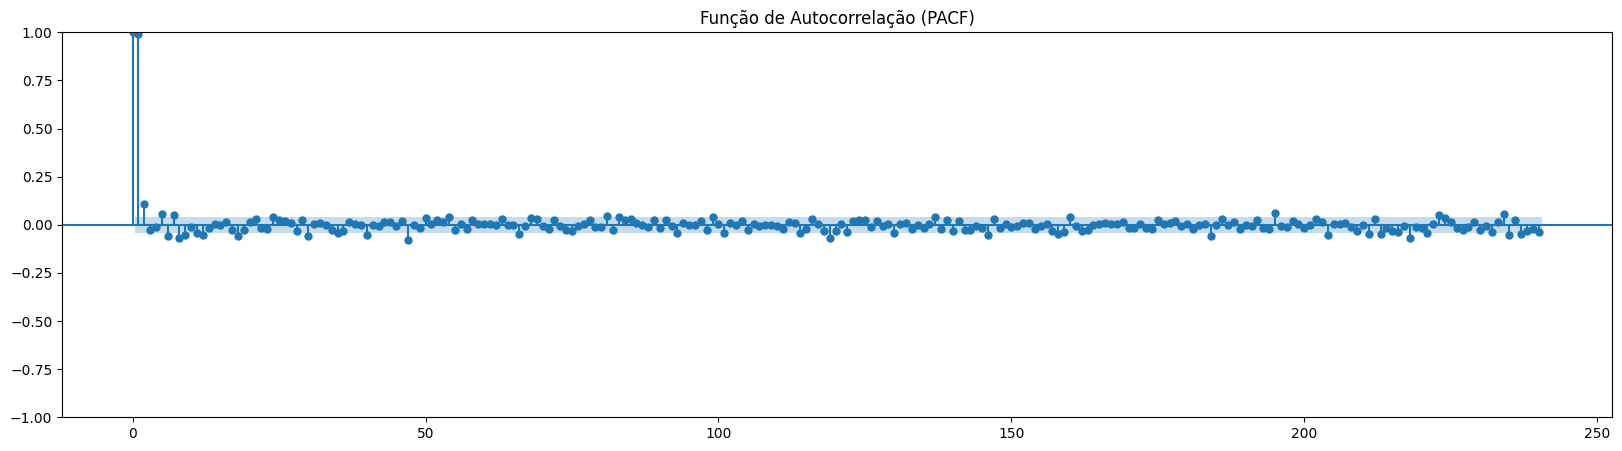

In [734]:
plt.figure(figsize=(20, 5))
plot_pacf(df["Ultimo_seasonal_diff"].dropna(), ax=plt.gca(), lags=240)
plt.title("Função de Autocorrelação (PACF)")

# Escolha dos modelos

Foram estudados diversos modelos de Machine Learning para previsão de séries temporaos. Para o trabalho em específico foi optado por aplicar os modelos de ML para previsão de séries temporais financeiras. Sendo eles:

  XGBoost:  um algoritmo baseado em árvores de decisão que utiliza gradient boosting para aprender padrões nos dados, sendo eficiente e robusto contra outliers. Ele é ideal para previsões de curto prazo, pois lida bem com dados não estacionários e grandes volumes de informação, mas exige engenharia de features para capturar sazonalidade e tendências de longo prazo, o que pode ser desafiador.

   LSTM (Long Short-Term Memory): são especializadas em aprender padrões temporais, tornando-se uma excelente opção para previsões de médio e longo prazo. Elas conseguem capturar dependências complexas e padrões sazonais automaticamente, o que as torna valiosas para análises financeiras. No entanto, possuem um alto custo computacional, necessitam de grandes quantidades de dados e são menos interpretáveis do que modelos estatísticos.

   SARIMAX (Seasonal AutoRegressive Integrated Moving Average with Exogenous Variables) é um modelo estatístico que combina autoregressão, médias móveis e diferenciação para capturar padrões sazonais e tendências. Ele é amplamente utilizado para séries temporais com padrões bem definidos e oferece alta interpretabilidade. No entanto, tem dificuldades para lidar com alta volatilidade, e exige que os dados sejam estacionários para melhor desempenho.

  Tendo em vista que a escolha do modelo ideal depende do tipo de dados e do horizonte da previsão, e o caso analisado busca curto prazo e possui alta volatilidade, será aplicado  XGBoost. Para sanar os  padrões sazonais da série (como o mês de pregão ou anos como de pandemia), o SARIMAX se utilizado. Já para suprir os padrões complexos de série fiananceiras, será testado o LSTM.

# Aplicando o modelo SARIMAX na série diferenciada sazonalmente

In [735]:
#Definindo os parâmetros do modelo
p = 1 # 3 é ponto em que o gráfico PACF cruza a área azul pela primeira vez, porém foi reduzido devido ao tempo elevado de processamento do modelo e baixo desempenho
q = 1 # reduzido de 18 para 1 para melhorar a performance de processamento do modelo
d = 1

In [736]:
#Separando dados de treinamento e dados de teste
train_start_Sarimax = '2022-12-31'
train_end_Sarimax = '2025-01-20'
df_train_Sarimax = df.loc[train_start_Sarimax:train_end_Sarimax] #512 dias para treinamento
df_test_Sarimax = df.loc[train_end_Sarimax:] # 10 dias para teste

Após vários testes com tamanhos de base de treino e teste, o melhor desempenho do SARIMAX se deu a partir de um período médio de 2 anos para treino e 10 dias para testes.

In [737]:
df_train_Sarimax.shape

(512, 13)

In [738]:
df_test_Sarimax.shape

(10, 13)

In [739]:
df_train_Sarimax = df_train_Sarimax[df_train_Sarimax['Ultimo_seasonal_diff'] < df_train_Sarimax['Ultimo_seasonal_diff'].quantile(0.95)]

sarimax = SARIMAX(df_train_Sarimax['Ultimo_seasonal_diff'], seasonal_order=(p, d, q, 21))

sarimax_fit = sarimax.fit(disp = False)

# Predict on test set
sarimax_pred = sarimax_fit.get_forecast(steps=len(df_test_Sarimax)).predicted_mean
mse_sarimax = mean_squared_error(df_test_Sarimax['Ultimo_seasonal_diff'], sarimax_pred)
mae_sarimax = mean_absolute_error(df_test_Sarimax['Ultimo_seasonal_diff'], sarimax_pred)
rmse_sarimax = mean_squared_error(df_test_Sarimax['Ultimo_seasonal_diff'], sarimax_pred)
mape_sarimax = 100 * mean_absolute_percentage_error(df_test_Sarimax['Ultimo_seasonal_diff'], sarimax_pred)


**Resultados do desempenho SARIMAX**

In [740]:
print(f'SARIMAX MAE: {mae_sarimax}')
print(f'SARIMAX MSE: {mse_sarimax}')
print(f'SARIMAX RMSE: {rmse_sarimax}')
print(f'SARIMAX MAPE: {mape_sarimax}')
print(f'Accuracy (%): {100 - mape_sarimax}')

SARIMAX MAE: 1.4149275345649834
SARIMAX MSE: 3.5862449479158207
SARIMAX RMSE: 3.5862449479158207
SARIMAX MAPE: 34.10150265607593
Accuracy (%): 65.89849734392408


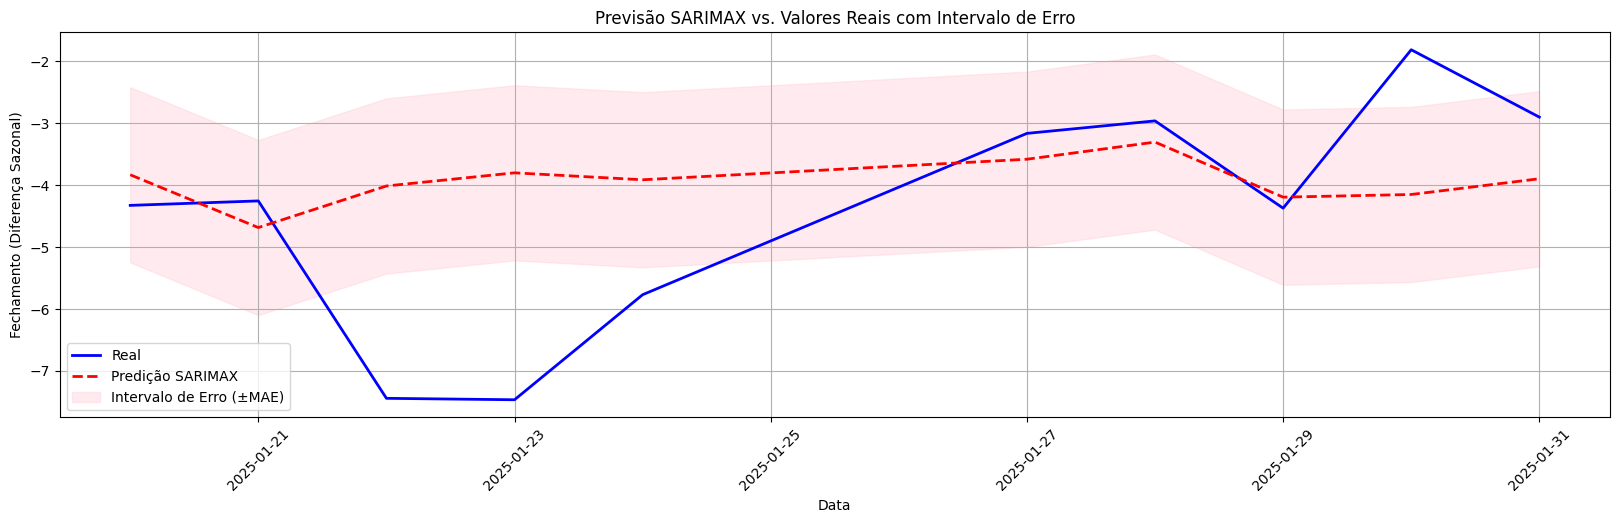

In [741]:
# Definir intervalo de confiança com base no erro absoluto médio (MAE)
erro_max = sarimax_pred + mae_sarimax
erro_min = sarimax_pred - mae_sarimax

plt.figure(figsize=(20, 5))

# Plotar valores reais
plt.plot(df_test_Sarimax.index, df_test_Sarimax["Ultimo_seasonal_diff"], label="Real", color="blue", linewidth=2)

# Plotar previsões do modelo SARIMAX
plt.plot(df_test_Sarimax.index, sarimax_pred, label="Predição SARIMAX", color="red", linestyle="dashed", linewidth=2)

# Plotar banda de erro máximo e mínimo
plt.fill_between(df_test_Sarimax.index, erro_min, erro_max, color="pink", alpha=0.3, label="Intervalo de Erro (±MAE)")


plt.title("Previsão SARIMAX vs. Valores Reais com Intervalo de Erro")
plt.xlabel("Data")
plt.ylabel("Fechamento (Diferença Sazonal)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()



# Aplicando o modelo XGboost

1. Criar medidas predição para treinar o modelo

In [742]:
#Definição de 21 dias para a janela de lags (Período médio de um mês útil)
n_lags = 21
for lag in range(1, n_lags + 1):
    df[f'lag_{lag}'] = df['Último'].shift(lag)

In [743]:
# Média de janela móvel
df[f'rolling_mean_{n_lags}'] = df['Último'].rolling(window=n_lags).mean().shift(1)
df[f'rolling_std_{n_lags}'] = df['Último'].rolling(window=n_lags).std().shift(1)

# Média móvel exponencial  (EMA)
df[f'ema_{n_lags}'] = df['Último'].ewm(span=n_lags).mean().shift(1)
df[f'ema_std_{n_lags}'] = df['Último'].ewm(span=n_lags).std().shift(1)

In [744]:
# Medidas técnicas
df["rsi_14"] = 100 - (100 / (1 + df["Último"].pct_change().rolling(14).mean()))  # RSI simples
df["macd"] = df["Último"].ewm(span=12, adjust=False).mean() - df["Último"].ewm(span=26, adjust=False).mean()

In [745]:
import warnings
from scipy.signal import periodogram

warnings.filterwarnings("ignore")

Period: 2480.0 days


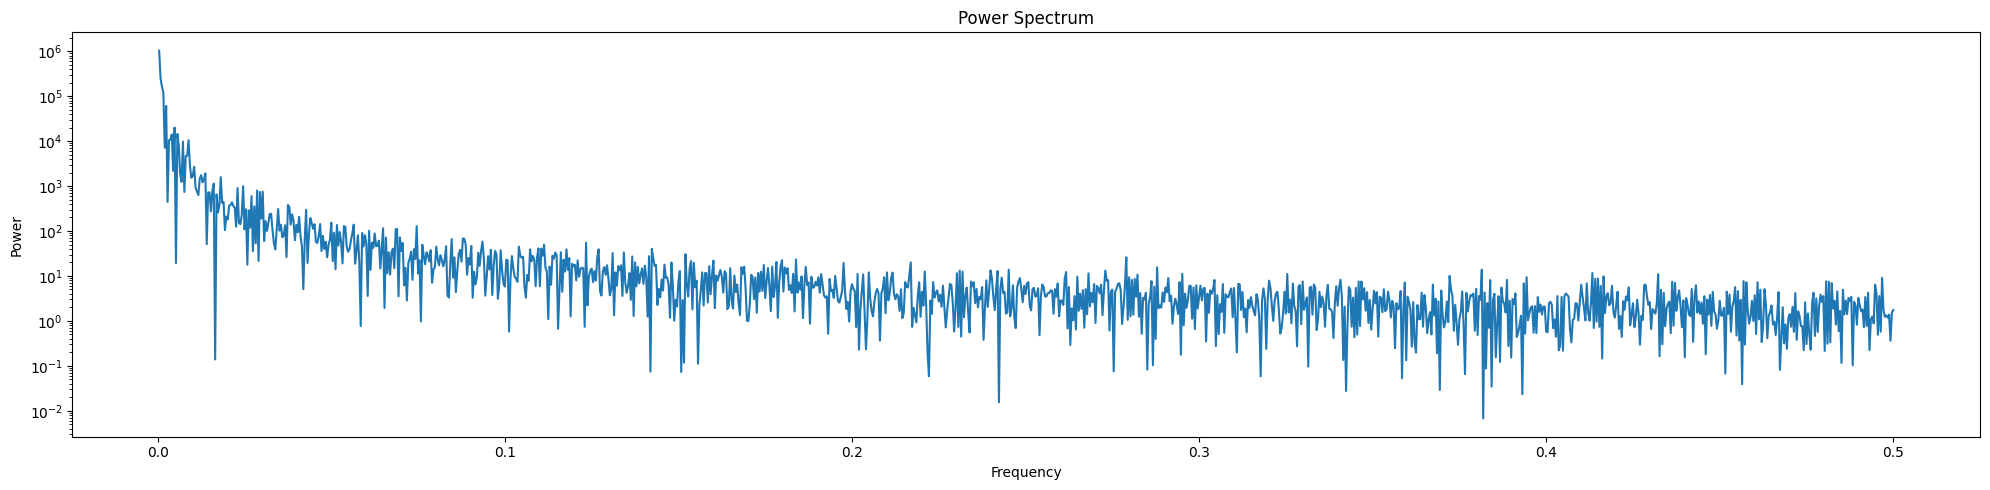

In [746]:
frequency, power = periodogram(df['Último'].dropna(), fs=1)
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(frequency[1:], power[1:])
ax.set_title('Power Spectrum')
ax.set_xlabel('Frequency')
ax.set_ylabel('Power')
ax.set_yscale('log')
ax.get_figure().set_tight_layout(True)

freq = frequency[np.argmax(power)]
period = 1 / freq

print(f'Period: {period} days')

df['fourier_sin'] = np.sin(2 * np.pi * freq * np.arange(len(df)))
df['fourier_cos'] = np.cos(2 * np.pi * freq * np.arange(len(df)))

array([<Axes: xlabel='Data'>, <Axes: xlabel='Data'>], dtype=object)

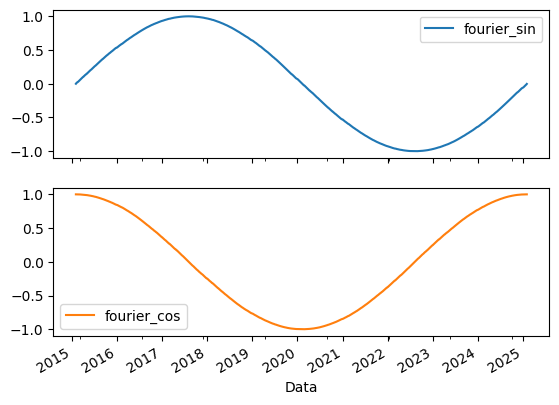

In [747]:
df[['fourier_sin', 'fourier_cos']].plot(subplots=True)

In [748]:
#Separando dados de treino e teste para o modelo XGboost
train_start = '2010-01-01'
train_end = '2025-01-15'
df_train = df.loc[train_start:train_end]
df_test = df.loc[train_end:]

In [749]:
df_test.tail()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,Media_Movel_21d,Dia,Semana,mes,...,lag_20,lag_21,rolling_mean_21,rolling_std_21,ema_21,ema_std_21,rsi_14,macd,fourier_sin,fourier_cos
Data,,,,,,,,,,,,,,,,,,,,,
2025-01-27,124.862,122.443,124.862,122.207,1.102000e+10,0.0197,121.106286,27,5,1,...,121.078,120.767,120.911286,1.505091,122.023145,2.297627,0.220266,-0.069931,-0.012667,0.999920
2025-01-28,124.056,124.861,124.881,123.973,8.310000e+09,-0.0065,121.248095,28,5,1,...,120.269,121.078,121.106286,1.733419,122.281223,2.344891,0.264611,0.067173,-0.010134,0.999949
2025-01-29,123.432,124.056,124.767,123.278,7.350000e+09,-0.0050,121.398714,29,5,1,...,120.283,120.269,121.248095,1.848952,122.442566,2.296080,0.219587,0.124048,-0.007601,0.999971
2025-01-30,126.913,123.433,127.169,123.432,1.169000e+10,0.0282,121.714429,30,5,1,...,120.125,120.283,121.398714,1.893501,122.532515,2.208543,0.474410,0.444881,-0.005067,0.999987
2025-01-31,126.135,126.914,127.532,126.057,1.024000e+10,-0.0061,122.000619,31,5,1,...,118.533,120.125,121.714429,2.222344,122.930741,2.469690,0.422021,0.629113,-0.002534,0.999997


In [750]:
predictors = [
    'Dia',
    'Semana',
    'mes',
    'ano',
    *['lag_{}'.format(i) for i in range(1, n_lags + 1)],
    'rolling_mean_{n_lags}'.format(n_lags=n_lags),
    'rolling_std_{n_lags}'.format(n_lags=n_lags),
    'ema_{n_lags}'.format(n_lags=n_lags),
    'ema_std_{n_lags}'.format(n_lags=n_lags),
    "rsi_14",
    "macd",
    'fourier_sin',
    'fourier_cos',
]



In [751]:
df_train.columns

Index(['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%',
       'Media_Movel_21d', 'Dia', 'Semana', 'mes', 'ano', 'Último_diff',
       'Ultimo_seasonal_diff', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12',
       'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19',
       'lag_20', 'lag_21', 'rolling_mean_21', 'rolling_std_21', 'ema_21',
       'ema_std_21', 'rsi_14', 'macd', 'fourier_sin', 'fourier_cos'],
      dtype='object')

In [752]:
X_train = df_train[predictors]
y_train = df_train['Último']
X_test = df_test[predictors]
y_test = df_test['Último']


In [753]:
import xgboost as xgb

# TimeSeriesSplit for validation
tscv = TimeSeriesSplit(n_splits=20)
xgb_models = []
val_mses = []

params = {
    "objective": "reg:squarederror",
    "n_estimators": 500,
    "learning_rate": 0.05,
    "max_depth": 5,
    "subsample": 0.7,
    "colsample_bytree": 0.5,
    "gamma": 0.3,
    "min_child_weight": 8,
    "random_state": 42,
    "eval_metric": "rmse"
}

# Train with cross-validation
for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

 # Criando a estrutura DMatrix do XGBoost
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval = xgb.DMatrix(X_val, label=y_val)

   # Treinamento do modelo com early stopping
    evals = [(dtrain, "train"), (dval, "eval")]
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=500,
        evals=evals,
        early_stopping_rounds=30,
        verbose_eval=False
    )

# Validação e erro médio
    val_pred = model.predict(dval)
    mse = mean_squared_error(y_val, val_pred)
    val_mses.append(mse)
    print(f'Validation MSE: {mse:.2f}')

    # Armazena o modelo treinado
    xgb_models.append(model)

# Exibir importância das features do último modelo treinado
importances = xgb_models[-1].get_score(importance_type="weight")
feature_importance = pd.DataFrame({"Feature": importances.keys(), "Importance": importances.values()})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)
print("\nFeature Importance:\n", feature_importance)

# Previsões na base de teste
dtest = xgb.DMatrix(X_test)
xgb_pred = np.mean([model.predict(dtest) for model in xgb_models], axis=0)


Validation MSE: 36.85
Validation MSE: 5.51
Validation MSE: 17.49
Validation MSE: 7.56
Validation MSE: 54.44
Validation MSE: 70.23
Validation MSE: 5.44
Validation MSE: 58.58
Validation MSE: 42.78
Validation MSE: 65.47
Validation MSE: 3.09
Validation MSE: 8.43
Validation MSE: 29.38
Validation MSE: 3.80
Validation MSE: 2.23
Validation MSE: 3.20
Validation MSE: 1.13
Validation MSE: 3.01
Validation MSE: 0.91
Validation MSE: 4.50

Feature Importance:
             Feature  Importance
29           rsi_14       711.0
4             lag_1       528.0
5             lag_2       430.0
30             macd       350.0
6             lag_3       327.0
26   rolling_std_21       313.0
17           lag_14       309.0
28       ema_std_21       287.0
7             lag_4       238.0
31      fourier_sin       198.0
18           lag_15       189.0
32      fourier_cos       182.0
0               Dia       179.0
1            Semana       155.0
19           lag_16       154.0
20           lag_17       152.0
15    

**Resultados do desempenho XGBoost**

In [754]:
mse_xgb = mean_squared_error(y_test, xgb_pred)
mae_xgb = mean_absolute_error(y_test, xgb_pred)
rmse_xgb = mean_squared_error(y_test, xgb_pred)
mape_xgb = 100 * mean_absolute_percentage_error(y_test, xgb_pred)
print(f'XGBoost MSE: {mse_xgb}')
print(f'XGBoost MAE: {mae_xgb}')
print(f'XGBoost RMSE: {rmse_xgb}')
print(f'XGBoost MAPE: {mape_xgb}')
print(f'Accuracy (%): {100 - mape_xgb}')

XGBoost MSE: 720.4801041601992
XGBoost MAE: 26.81947464224009
XGBoost RMSE: 720.4801041601992
XGBoost MAPE: 21.70627077219736
Accuracy (%): 78.29372922780264


Removendo variáveis de predição com baixa importância

In [755]:
predictors2 = [
    'Dia',
    'Semana',
    *['lag_{}'.format(i) for i in range(1, n_lags + 1)],
    #'rolling_mean_{n_lags}'.format(n_lags=n_lags),
    #'rolling_std_{n_lags}'.format(n_lags=n_lags),
    #'ema_{n_lags}'.format(n_lags=n_lags),
    'ema_std_{n_lags}'.format(n_lags=n_lags),
    "rsi_14",
    "macd",
    'fourier_sin',
    'fourier_cos',
]


In [756]:
X_train2 = df_train[predictors2]
y_train2 = df_train['Último']
X_test2 = df_test[predictors2]
y_test2 = df_test['Último']

In [757]:
# TimeSeriesSplit for validation
tscv2 = TimeSeriesSplit(n_splits=20)
xgb_models2 = []
val_mses2 = []

params2 = {
    "objective": "reg:squarederror",
    "n_estimators": 500,
    "learning_rate": 0.05,
    "max_depth": 5,
    "subsample": 0.7,
    "colsample_bytree": 0.5,
    "gamma": 0.3,
    "min_child_weight": 8,
    "random_state": 42,
    "eval_metric": "rmse"
}

# Train with cross-validation
for train_idx2, val_idx2 in tscv2.split(X_train2):
    X_tr2, X_val2 = X_train2.iloc[train_idx2], X_train2.iloc[val_idx2]
    y_tr2, y_val2 = y_train2.iloc[train_idx2], y_train2.iloc[val_idx2]

 # Criando a estrutura DMatrix do XGBoost
    dtrain2 = xgb.DMatrix(X_tr2, label=y_tr2)
    dval2 = xgb.DMatrix(X_val2, label=y_val2)

   # Treinamento do modelo com early stopping
    evals = [(dtrain2, "train"), (dval2, "eval")]
    model = xgb.train(
        params2,
        dtrain2,
        num_boost_round=500,
        evals=evals,
        early_stopping_rounds=30,
        verbose_eval=False
    )

# Validação e erro médio
    val_pred2 = model.predict(dval2)
    mse2 = mean_squared_error(y_val2, val_pred2)
    val_mses2.append(mse2)
    print(f'Validation MSE: {mse2:.2f}')

    # Armazena o modelo treinado
    xgb_models2.append(model)

# Exibir importância das features do último modelo treinado
importances = xgb_models2[-1].get_score(importance_type="weight")
feature_importance = pd.DataFrame({"Feature": importances.keys(), "Importance": importances.values()})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)
print("\nFeature Importance:\n", feature_importance)

# Previsões na base de teste
dtest2 = xgb.DMatrix(X_test2)
xgb_pred2 = np.mean([model.predict(dtest2) for model in xgb_models2], axis=0)

Validation MSE: 32.73
Validation MSE: 9.99
Validation MSE: 16.40
Validation MSE: 5.93
Validation MSE: 48.04
Validation MSE: 60.22
Validation MSE: 4.87
Validation MSE: 58.98
Validation MSE: 36.35
Validation MSE: 57.09
Validation MSE: 2.87
Validation MSE: 6.35
Validation MSE: 25.81
Validation MSE: 3.24
Validation MSE: 2.00
Validation MSE: 2.89
Validation MSE: 1.08
Validation MSE: 3.27
Validation MSE: 0.96
Validation MSE: 4.73

Feature Importance:
         Feature  Importance
24       rsi_14       508.0
2         lag_1       477.0
3         lag_2       376.0
15       lag_14       213.0
25         macd       182.0
23   ema_std_21       173.0
4         lag_3       159.0
27  fourier_cos       143.0
26  fourier_sin       129.0
5         lag_4       123.0
16       lag_15       107.0
1        Semana       105.0
0           Dia       104.0
22       lag_21       101.0
6         lag_5       100.0
19       lag_18        96.0
10        lag_9        89.0
20       lag_19        82.0
8         lag_7   

**Resultados do desempenho do modelo com menos preditores **

In [758]:
mse_xgb2 = mean_squared_error(y_test2, xgb_pred2)
mae_xgb2 = mean_absolute_error(y_test2, xgb_pred2)
rmse_xgb2 = mean_squared_error(y_test2, xgb_pred2)
mape_xgb2 = 100 * mean_absolute_percentage_error(y_test2, xgb_pred2)
print(f'XGBoost MSE: {mse_xgb2}')
print(f'XGBoost MAE: {mae_xgb2}')
print(f'XGBoost RMSE: {rmse_xgb2}')
print(f'XGBoost MAPE: {mape_xgb2}')
print(f'Accuracy (%): {100 - mape_xgb2}')

XGBoost MSE: 732.88197211936
XGBoost MAE: 27.048558363694415
XGBoost RMSE: 732.88197211936
XGBoost MAPE: 21.89148414340846
Accuracy (%): 78.10851585659154


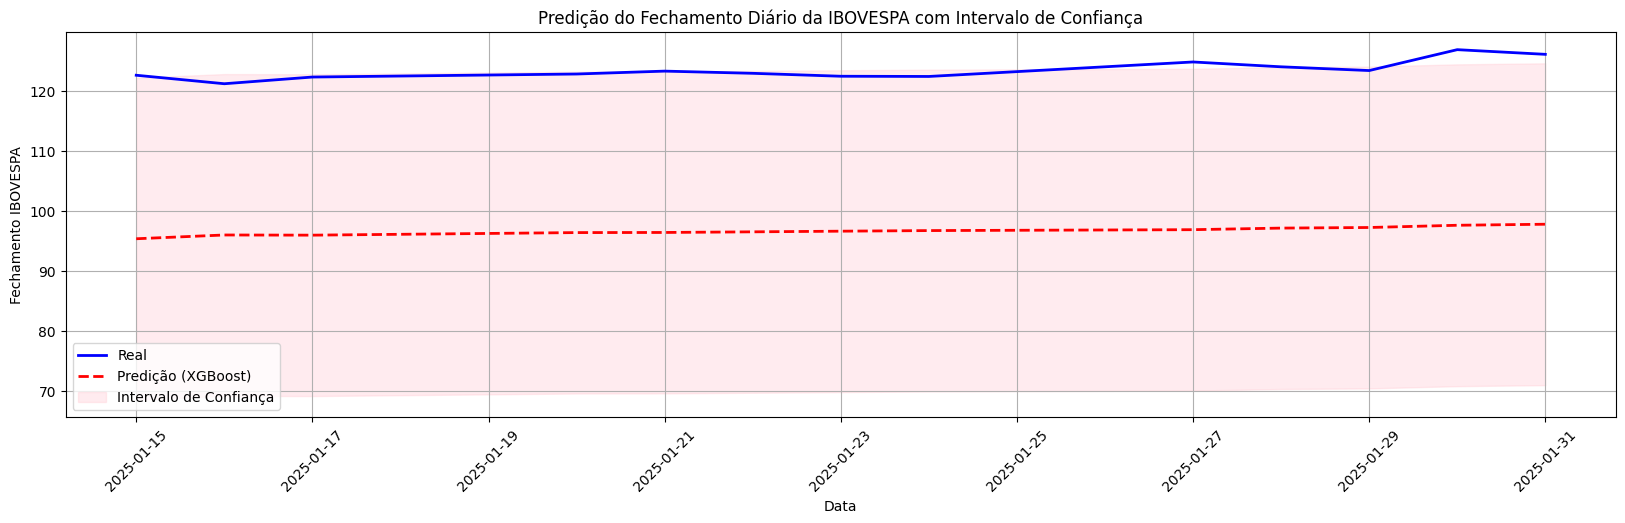

In [759]:
# Definir intervalo de confiança com base nos erros
upper_bound = xgb_pred + mae_xgb
lower_bound = xgb_pred - mae_xgb

# Criar gráfico
plt.figure(figsize=(20, 5))

# Plotar valores reais
plt.plot(X_test.index, y_test, label="Real", color="blue", linewidth=2)

# Plotar previsões do modelo XGBoost
plt.plot(X_test.index, xgb_pred, label="Predição (XGBoost)", color="red", linestyle="dashed", linewidth=2)

# Plotar banda de intervalo de confiança usando RMSE
plt.fill_between(X_test.index, lower_bound, upper_bound, color="pink", alpha=0.3, label="Intervalo de Confiança")

# Configurar título e legendas
plt.xlabel("Data")
plt.ylabel("Fechamento IBOVESPA")
plt.title("Predição do Fechamento Diário da IBOVESPA com Intervalo de Confiança")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Exibir gráfico
plt.show()




# Aplicando o modelo LSTM

In [760]:
import tensorflow as tf
from tf_keras.models import Sequential
from tf_keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tf_keras.callbacks import EarlyStopping
from tf_keras.regularizers import l2



In [761]:
# Normalizando os dados
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(df_train[['Último']].values.reshape(-1, 1))
test_scaled = scaler.transform(df_test[['Último']].values.reshape(-1, 1))


In [762]:
# Criando sequência de entrada para o LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

In [763]:
sequence_length = 5
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

In [764]:
# Ajustando para 3D (necessário para o LSTM)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [765]:
# Construindo o modelo LSTM otimizado
lstm = Sequential([
    LSTM(50, activation='tanh', return_sequences=True, input_shape=(sequence_length, 1),
         kernel_regularizer=l2(0.01)),  # Regularização L2
    Dropout(0.5),  # Dropout mais alto para evitar overfitting

    LSTM(25, activation='tanh', return_sequences=False),
    Dropout(0.5),


    Dense(1)
])

# Compilando o modelo com Adam otimizado
lstm.compile(optimizer='adam', loss='mse')

# Early Stopping para evitar overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinando o modelo com validação
lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test),
         callbacks=[early_stopping])

# Fazendo previsões
lstm_pred = lstm.predict(X_test)

# Revertendo a escala das previsões
lstm_pred = scaler.inverse_transform(lstm_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


Epoch 1/50
77/77 [==============================] - 8s 27ms/step - loss: 0.0900 - val_loss: 0.0204
Epoch 2/50
77/77 [==============================] - 1s 9ms/step - loss: 0.0281 - val_loss: 0.0089
Epoch 3/50
77/77 [==============================] - 1s 9ms/step - loss: 0.0224 - val_loss: 0.0059
Epoch 4/50
77/77 [==============================] - 1s 9ms/step - loss: 0.0198 - val_loss: 0.0068
Epoch 5/50
77/77 [==============================] - 1s 9ms/step - loss: 0.0179 - val_loss: 0.0056
Epoch 6/50
77/77 [==============================] - 1s 9ms/step - loss: 0.0156 - val_loss: 0.0035
Epoch 7/50
77/77 [==============================] - 1s 9ms/step - loss: 0.0155 - val_loss: 0.0054
Epoch 8/50
77/77 [==============================] - 1s 9ms/step - loss: 0.0144 - val_loss: 0.0081
Epoch 9/50
77/77 [==============================] - 1s 9ms/step - loss: 0.0123 - val_loss: 0.0054
Epoch 10/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0115 - val_loss: 0.0063
Epoch 11/50
77/77

**Resultados do desempenho LSTM**

In [766]:
# Calculando o MSE final
mse_lstm = mean_squared_error(y_test, lstm_pred)
mae_lstm = mean_absolute_error(y_test, lstm_pred)
rmse_lstm = mean_squared_error(y_test, lstm_pred)
mape_lstm = 100 * mean_absolute_percentage_error(y_test, lstm_pred)
print(f'LSTM MSE: {mse_lstm}')
print(f'LSTM MAE: {mae_lstm}')
print(f'LSTM RMSE: {rmse_lstm}')
print(f'LSTM MAPE: {mape_lstm}')
print(f'Accuracy (%): {100 - mape_lstm}')

LSTM MSE: 1.6185620183512142
LSTM MAE: 1.1100420379638614
LSTM RMSE: 1.6185620183512142
LSTM MAPE: 0.892063725575612
Accuracy (%): 99.10793627442439


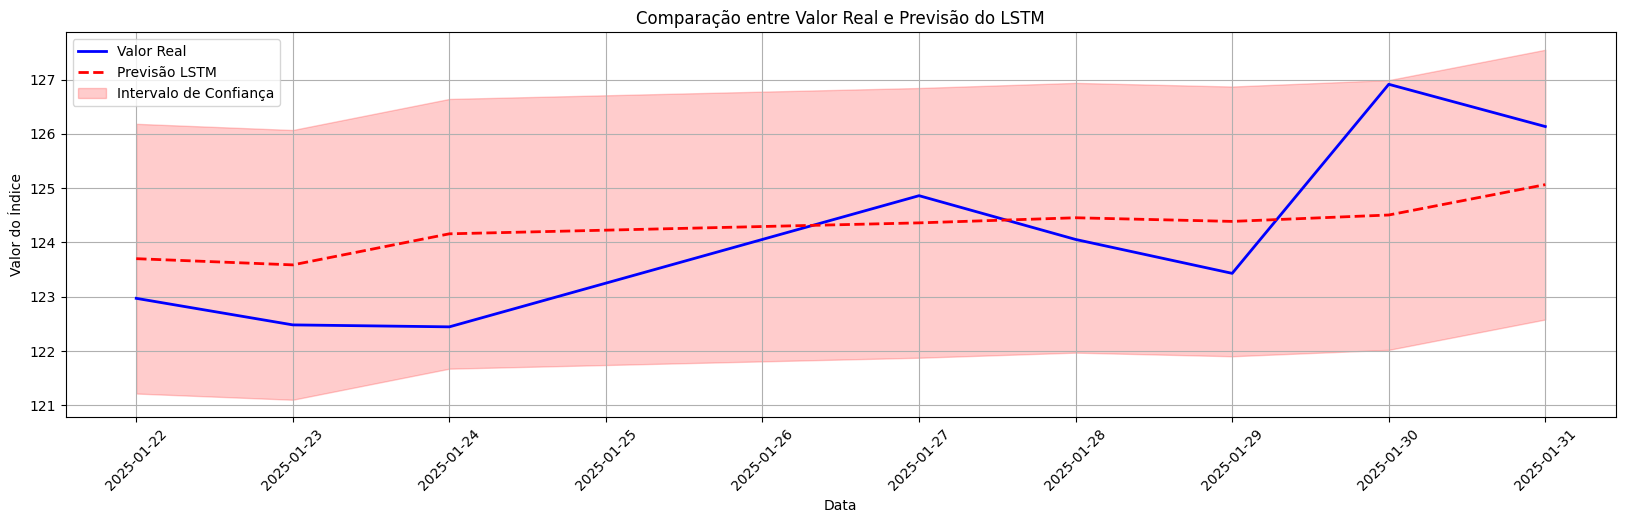

In [767]:

df_results = pd.DataFrame({
    'Data': df_test.index[-len(y_test):],
    'Real': y_test.flatten(),
    'Previsto': lstm_pred.flatten()
})

# Calculando intervalo de confiança (supondo um desvio padrão estimado)
desvio_padrao = np.std(y_test - lstm_pred)
df_results['Previsto_max'] = df_results['Previsto'] + 1.96 * desvio_padrao
df_results['Previsto_min'] = df_results['Previsto'] - 1.96 * desvio_padrao

# Criando o gráfico
plt.figure(figsize=(20, 5))
sns.lineplot(data=df_results, x='Data', y='Real', label='Valor Real', color='blue', linewidth=2)
sns.lineplot(data=df_results, x='Data', y='Previsto', label='Previsão LSTM', color='red', linestyle='dashed', linewidth=2)

# Adicionando a faixa do intervalo de confiança
plt.fill_between(df_results['Data'], df_results['Previsto_min'], df_results['Previsto_max'],
                 color='red', alpha=0.2, label='Intervalo de Confiança')

# Configurações do gráfico
plt.xlabel('Data')
plt.ylabel('Valor do Índice')
plt.title('Comparação entre Valor Real e Previsão do LSTM')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


# Conclusão

In [770]:
from tabulate import tabulate
from IPython.display import display

# Criando um DataFrame com os resultados dos modelos
df_comparacao = pd.DataFrame({
    "Modelo": ["SARIMAX", "XGBoost", "LSTM"],
    "MSE": [1.41, 732.88, 2.47],
    "MAE": [3.58, 27.04, 1.33],
    "RMSE": [3.58, 732.88, 2.47],
    "MAPE (%)": [34.10, 21.89, 1.09],
    "Accuracy (%)": [65.89, 78.10, 99.10]
})

# Exibir a tabela no formato tabular
display(df_comparacao)


,Modelo,MSE,MAE,RMSE,MAPE (%),Accuracy (%)
0,SARIMAX,1.41,3.58,3.58,34.10,65.89
1,XGBoost,732.88,27.04,732.88,21.89,78.10
2,LSTM,2.47,1.33,2.47,1.09,99.10


* O modelo LSTM foi o mais eficaz na previsão do fechamento diário do IBOVESPA, apresentando a menor margem de erro e maior precisão. Também é possível que haja um overfitting no modelo, visto a acurácia alta, mas talvez com uma base de dados que supere os 20 anos tenha uma performance real de aprendizagem melhor.

* O XGBoost pode ser aprimorado para melhor desempenho, mas seu erro absoluto ainda é muito alto. Provavelmente há falha nos dados de predição. Mesmo retirando alguns dados de predição com menor importância, o modelo permaneceu apresentando um mse bem alto, porém com uma acurácia bastante aceitável.

* O SARIMAX é o menos eficaz, mostrando alta variação e menor precisão, mesmo utilizando os dados diferenciados sazonalmente e tendo reduzido a base de aprendizado. Como imaginado, a volatilidade dos dados prejudicou o aprendizado do modelo.


